In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from keras.preprocessing.sequence import pad_sequences

import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import keras.backend as K 

from keras.callbacks import EarlyStopping,ModelCheckpoint

from keras.utils import np_utils
from keras.models import Sequential, load_model

from keras.layers import BatchNormalization, Conv1D, LSTM,Input, Dense, Dropout,TimeDistributed, Flatten,MaxPooling1D
from keras.optimizers import Adam
from keras.models import Model

from keras.callbacks import ReduceLROnPlateau
from keras.applications.mobilenet import MobileNet, decode_predictions
from keras.applications.resnet50 import ResNet50, decode_predictions

from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, classification_report


import random

from collections import Counter

import ast
import os
import cv2

Using TensorFlow backend.


# =================================================

In [2]:
all_data = pd.read_csv("true_split_data/dataset_1.csv")

# =================================================

In [2]:
path_dir = "E:/경희대학교/2019_2/데이터분석캡스톤디자인/quick_draw/quickdraw-doodle-recognition/top10/"
file_lst = os.listdir(path_dir)

In [3]:
all_data = pd.DataFrame()
for i in file_lst:
    print(i)
    tmp = pd.read_csv(path_dir + i)
    tmp = tmp[tmp["recognized"] == True]
    ttmp = tmp.iloc[:50000]
    all_data = pd.concat([all_data,ttmp],axis = 0)

airplane.csv
bear.csv
butterfly.csv
cat.csv
circle.csv
cloud.csv
dog.csv
door.csv
mouse.csv
star.csv


In [4]:
all_data['drawing'] = all_data['drawing'].apply(ast.literal_eval)

In [5]:
all_data.shape

(500000, 6)

In [6]:
word_lst = list(all_data['word'].unique())

In [7]:
train2, test = train_test_split(all_data, test_size=0.3, shuffle = True, 
                                random_state = 42,
                                stratify = all_data['word'])

In [8]:
train, valid=  train_test_split(train2, test_size=0.3, shuffle = True,
                                random_state= 42,
                                stratify = train2['word'])

In [9]:
train.reset_index()

,index,countrycode,drawing,key_id,recognized,timestamp,word
0,10343,BR,"[[[75, 77, 85, 96, 88, 97, 87, 86, 90, 114, 11...",5066628142202880,True,2017-01-27 20:36:06.652010,bear
1,10788,GB,"[[[27, 46, 67, 83, 97, 113, 123, 130, 203, 255...",6301025445085184,True,2017-03-28 21:30:18.115600,star
2,10033,US,"[[[47, 37, 24, 18, 15, 15, 22, 30, 42, 63, 76,...",5868152388845568,True,2017-01-27 02:22:31.794880,cloud
3,39276,MX,"[[[58, 41, 17, 4, 0, 3, 16, 39, 56], [15, 4, 3...",6746232816926720,True,2017-01-28 20:55:21.474700,bear
4,5099,US,"[[[83, 71, 32, 25, 10, 5, 2, 1, 19, 34, 65, 71...",5098434669314048,True,2017-03-26 06:43:12.735870,dog
...,...,...,...,...,...,...,...
244995,26969,GB,"[[[137, 128, 117, 67, 25, 0, 18, 49, 102, 116,...",6349830433538048,True,2017-03-26 18:40:08.820320,mouse
244996,14433,US,"[[[28, 92, 147, 147, 144, 148, 144, 104, 34], ...",6362241194524672,True,2017-03-11 15:00:08.495430,door
244997,35990,US,"[[[78, 42, 28, 16, 16, 27, 43, 75, 91, 98, 98,...",4922004023017472,True,2017-03-22 00:36:32.252780,dog
244998,20527,US,"[[[188, 164, 133, 86, 64, 64, 73, 92, 126, 174...",4682216489615360,True,2017-01-31 19:34:54.671140,dog


In [10]:
print(train.shape)
print(valid.shape)
print(test.shape)

(245000, 6)
(105000, 6)
(150000, 6)


In [11]:
word_le = LabelEncoder()
word_le.fit(all_data['word'])

LabelEncoder()

In [12]:
word_le.classes_

array(['airplane', 'bear', 'butterfly', 'cat', 'circle', 'cloud', 'dog',
       'door', 'mouse', 'star'], dtype=object)

### Split

In [13]:
size = 64
word_num = len(word_lst)
BASE_SIZE = 256

#### cv2.line
* img: 선분이 그려질 이미지  
* (x1,y1) 선분의 시작점
* (x2,y2) 선분의 끝점
* color: 색상(0~255)
* thickness

In [14]:
def reshape_draw(rs, size=256, lw=6):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for s in rs:
        for i in range(len(s[0]) - 1):
            cv2.line(img, (s[0][i], s[1][i]), (s[0][i + 1], s[1][i + 1]), 255, lw) 
            #c2.line(img:이미지 파일, pt1:시작점 좌표(x,y), pt2:종료점좌표(x,y), color:색상(0~255), thickness:선두께(defalut1), lineType:선종류, shift)
            
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size)) #cv2.resize(원본 이미지, 결과 이미지 크기, 보간법)
    else:
        return img

In [15]:
def drawing_make_array(df, size = size, lw = 6):
    x = np.zeros((len(df),size,size))
    for i, rs in enumerate(df.drawing.values):
        x[i] = reshape_draw(rs,size=size,lw=lw)
    x = x/255 # 정규화
    x = x.reshape((len(df),size,size,1)).astype(np.float32)
    return x

In [17]:
train_X = drawing_make_array(train, size)
train_y = to_categorical(word_le.transform(train['word'].values))

In [18]:
valid_X = drawing_make_array(valid, size)
valid_y = to_categorical(word_le.transform(valid['word'].values))

In [19]:
test_X = drawing_make_array(test, size)
test_y = to_categorical(word_le.transform(test['word'].values))

In [20]:
train_X.shape

(245000, 64, 64, 1)

In [21]:
valid_X.shape

(105000, 64, 64, 1)

In [22]:
test_X.shape

(150000, 64, 64, 1)

## Model

In [23]:
STEPS= 100
batch = 100
epochs = 100

In [24]:
datagen = ImageDataGenerator()

In [25]:
K.clear_session()

In [26]:
base_model = ResNet50(include_top=False, input_shape=(size, size, 1), weights=None, classes=word_num)

C:\Users\julia\Desktop\tf\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [27]:
x = base_model.output
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(word_num, activation='softmax')(x)

In [28]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [29]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy])

In [30]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [31]:
check_point = ModelCheckpoint('model_1223_resnet_v3.h5', monitor='val_loss', mode='min', save_best_only=True)
reduceRP = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=10,
                          mode='min', min_lr= 0.00001, verbose=1)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10)

callbacks = [check_point, early, reduceRP]

In [32]:
hist = model.fit_generator(
    datagen.flow(train_X,train_y,batch_size = batch),
    steps_per_epoch = STEPS,
    validation_steps=STEPS, epochs=epochs, verbose=1,
    validation_data=(valid_X, valid_y),
    callbacks = callbacks
)

Epoch 1/100
100/100 [==============================] - 242s 2s/step - loss: 2.4298 - categorical_crossentropy: 2.4298 - categorical_accuracy: 0.0995 - val_loss: 2.3026 - val_categorical_crossentropy: 2.3026 - val_categorical_accuracy: 0.1000
Epoch 2/100
100/100 [==============================] - 234s 2s/step - loss: 2.3025 - categorical_crossentropy: 2.3025 - categorical_accuracy: 0.1000 - val_loss: 2.3026 - val_categorical_crossentropy: 2.3027 - val_categorical_accuracy: 0.1000
Epoch 3/100
100/100 [==============================] - 234s 2s/step - loss: 2.3027 - categorical_crossentropy: 2.3027 - categorical_accuracy: 0.0971 - val_loss: 2.3026 - val_categorical_crossentropy: 2.3026 - val_categorical_accuracy: 0.1000
Epoch 4/100
100/100 [==============================] - 237s 2s/step - loss: 2.3027 - categorical_crossentropy: 2.3027 - categorical_accuracy: 0.0952 - val_loss: 2.3026 - val_categorical_crossentropy: 2.3026 - val_categorical_accuracy: 0.1000
Epoch 5/100
100/100 [===========

In [35]:
hist2 = model.fit_generator(
    datagen.flow(train_X,train_y,batch_size = batch),
    steps_per_epoch = STEPS,
    validation_steps=STEPS, epochs=epochs, verbose=1,
    validation_data=(valid_X, valid_y),
    callbacks = callbacks
)

Epoch 1/100
100/100 [==============================] - 210s 2s/step - loss: 2.3026 - categorical_crossentropy: 2.3026 - categorical_accuracy: 0.0979 - val_loss: 2.3026 - val_categorical_crossentropy: 2.3026 - val_categorical_accuracy: 0.1000
Epoch 2/100
100/100 [==============================] - 219s 2s/step - loss: 2.3025 - categorical_crossentropy: 2.3025 - categorical_accuracy: 0.1053 - val_loss: 2.3026 - val_categorical_crossentropy: 2.3026 - val_categorical_accuracy: 0.1000
Epoch 3/100
100/100 [==============================] - 225s 2s/step - loss: 2.3025 - categorical_crossentropy: 2.3025 - categorical_accuracy: 0.1013 - val_loss: 2.3027 - val_categorical_crossentropy: 2.3027 - val_categorical_accuracy: 0.1000
Epoch 4/100
100/100 [==============================] - 229s 2s/step - loss: 2.3028 - categorical_crossentropy: 2.3028 - categorical_accuracy: 0.0949 - val_loss: 2.3026 - val_categorical_crossentropy: 2.3026 - val_categorical_accuracy: 0.1000
Epoch 5/100
100/100 [===========

In [33]:
import winsound as ws

def beepsound():
    freq = 2000    # range : 37 ~ 32767
    dur = 1000     # ms
    ws.Beep(freq, dur) # winsound.Beep(frequency, duration)


In [34]:
print(beepsound())

None


In [51]:
hist2 = model.fit_generator(
    datagen.flow(train_X,train_y,batch_size = batch),
    steps_per_epoch = STEPS,
    validation_steps=STEPS, epochs=epochs, verbose=1,
    validation_data=(valid_X, valid_y),
    callbacks = callbacks
)

Epoch 1/100
100/100 [==============================] - 98s 978ms/step - loss: 4.6052 - categorical_crossentropy: 4.6052 - categorical_accuracy: 0.0107 - val_loss: 4.6052 - val_categorical_crossentropy: 4.6052 - val_categorical_accuracy: 0.0100
Epoch 2/100
100/100 [==============================] - 103s 1s/step - loss: 4.6053 - categorical_crossentropy: 4.6053 - categorical_accuracy: 0.0088 - val_loss: 4.6053 - val_categorical_crossentropy: 4.6052 - val_categorical_accuracy: 0.0100
Epoch 3/100
100/100 [==============================] - 104s 1s/step - loss: 4.6053 - categorical_crossentropy: 4.6053 - categorical_accuracy: 0.0097 - val_loss: 4.6053 - val_categorical_crossentropy: 4.6053 - val_categorical_accuracy: 0.0100
Epoch 4/100
100/100 [==============================] - 106s 1s/step - loss: 4.6053 - categorical_crossentropy: 4.6053 - categorical_accuracy: 0.0101 - val_loss: 4.6053 - val_categorical_crossentropy: 4.6053 - val_categorical_accuracy: 0.0100
Epoch 5/100
100/100 [=========

100/100 [==============================] - 101s 1s/step - loss: 4.6054 - categorical_crossentropy: 4.6054 - categorical_accuracy: 0.0093 - val_loss: 4.6052 - val_categorical_crossentropy: 4.6052 - val_categorical_accuracy: 0.0100
Epoch 68/100
100/100 [==============================] - 101s 1s/step - loss: 4.6053 - categorical_crossentropy: 4.6053 - categorical_accuracy: 0.0109 - val_loss: 4.6052 - val_categorical_crossentropy: 4.6052 - val_categorical_accuracy: 0.0100
Epoch 69/100
100/100 [==============================] - 101s 1s/step - loss: 4.6054 - categorical_crossentropy: 4.6054 - categorical_accuracy: 0.0098 - val_loss: 4.6052 - val_categorical_crossentropy: 4.6052 - val_categorical_accuracy: 0.0100
Epoch 70/100
100/100 [==============================] - 101s 1s/step - loss: 4.6054 - categorical_crossentropy: 4.6054 - categorical_accuracy: 0.0096 - val_loss: 4.6052 - val_categorical_crossentropy: 4.6052 - val_categorical_accuracy: 0.0100
Epoch 71/100
100/100 [===================

In [ ]:
hist3 = model.fit_generator(
    datagen.flow(train_X,train_y,batch_size = batch),
    steps_per_epoch = STEPS,
    validation_steps=STEPS, epochs=epochs, verbose=1,
    validation_data=(valid_X, valid_y),
    callbacks = callbacks
)

Epoch 1/100
100/100 [==============================] - 98s 980ms/step - loss: 4.6051 - categorical_crossentropy: 4.6051 - categorical_accuracy: 0.0095 - val_loss: 4.6052 - val_categorical_crossentropy: 4.6052 - val_categorical_accuracy: 0.0100
Epoch 2/100
100/100 [==============================] - 101s 1s/step - loss: 4.6052 - categorical_crossentropy: 4.6052 - categorical_accuracy: 0.0096 - val_loss: 4.6052 - val_categorical_crossentropy: 4.6052 - val_categorical_accuracy: 0.0100
Epoch 3/100
100/100 [==============================] - 101s 1s/step - loss: 4.6051 - categorical_crossentropy: 4.6051 - categorical_accuracy: 0.0104 - val_loss: 4.6052 - val_categorical_crossentropy: 4.6052 - val_categorical_accuracy: 0.0100
Epoch 4/100
100/100 [==============================] - 101s 1s/step - loss: 4.6051 - categorical_crossentropy: 4.6051 - categorical_accuracy: 0.0123 - val_loss: 4.6052 - val_categorical_crossentropy: 4.6052 - val_categorical_accuracy: 0.0100
Epoch 5/100
100/100 [=========

100/100 [==============================] - 102s 1s/step - loss: 4.6053 - categorical_crossentropy: 4.6053 - categorical_accuracy: 0.0102 - val_loss: 4.6052 - val_categorical_crossentropy: 4.6052 - val_categorical_accuracy: 0.0100
Epoch 68/100
100/100 [==============================] - 102s 1s/step - loss: 4.6054 - categorical_crossentropy: 4.6054 - categorical_accuracy: 0.0095 - val_loss: 4.6052 - val_categorical_crossentropy: 4.6052 - val_categorical_accuracy: 0.0100
Epoch 69/100
100/100 [==============================] - 102s 1s/step - loss: 4.6053 - categorical_crossentropy: 4.6053 - categorical_accuracy: 0.0092 - val_loss: 4.6052 - val_categorical_crossentropy: 4.6052 - val_categorical_accuracy: 0.0100
Epoch 70/100
100/100 [==============================] - 102s 1s/step - loss: 4.6053 - categorical_crossentropy: 4.6053 - categorical_accuracy: 0.0085 - val_loss: 4.6052 - val_categorical_crossentropy: 4.6052 - val_categorical_accuracy: 0.0100
Epoch 71/100
100/100 [===================

In [31]:
K.clear_session()
base_model = MobileNet(input_shape=(size, size, 1), include_top=False, weights=None, classes=word_num)

In [32]:
x = base_model.output
x = Flatten()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(word_num, activation='softmax')(x)

In [33]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [34]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy])


In [35]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 65, 65, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128 

In [36]:
check_point = ModelCheckpoint('model.h5', monitor='val_loss', mode='min', save_best_only=True,
                    save_weights_only=True)
reduceRP = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=10,
                          mode='min', min_lr= 0.0001, verbose=1)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15)

callbacks = [check_point, early, reduceRP]

In [37]:
hist = model.fit_generator(
    datagen.flow(train_X,train_y,batch_size = batch),
    steps_per_epoch = STEPS,
    validation_steps=STEPS, epochs=epochs, verbose=1,
    validation_data=(valid_X, valid_y),
    callbacks = callbacks
)

Epoch 1/100
100/100 [==============================] - 288s 3s/step - loss: 5.8698 - categorical_crossentropy: 5.8698 - categorical_accuracy: 0.0054 - val_loss: 5.8325 - val_categorical_crossentropy: 5.8325 - val_categorical_accuracy: 0.0029
Epoch 2/100
100/100 [==============================] - 139s 1s/step - loss: 5.6210 - categorical_crossentropy: 5.6210 - categorical_accuracy: 0.0092 - val_loss: 5.8489 - val_categorical_crossentropy: 5.8489 - val_categorical_accuracy: 0.0031
Epoch 3/100
100/100 [==============================] - 139s 1s/step - loss: 5.4970 - categorical_crossentropy: 5.4970 - categorical_accuracy: 0.0097 - val_loss: 5.8962 - val_categorical_crossentropy: 5.8962 - val_categorical_accuracy: 0.0029
Epoch 4/100
100/100 [==============================] - 140s 1s/step - loss: 5.3961 - categorical_crossentropy: 5.3961 - categorical_accuracy: 0.0130 - val_loss: 5.9486 - val_categorical_crossentropy: 5.9486 - val_categorical_accuracy: 0.0029
Epoch 5/100
100/100 [===========

Epoch 35/100
100/100 [==============================] - 152s 2s/step - loss: 4.4076 - categorical_crossentropy: 4.4076 - categorical_accuracy: 0.0791 - val_loss: 3.9329 - val_categorical_crossentropy: 3.9329 - val_categorical_accuracy: 0.1316
Epoch 36/100
100/100 [==============================] - 170s 2s/step - loss: 4.3794 - categorical_crossentropy: 4.3794 - categorical_accuracy: 0.0814 - val_loss: 3.8205 - val_categorical_crossentropy: 3.8205 - val_categorical_accuracy: 0.1467
Epoch 37/100
100/100 [==============================] - 160s 2s/step - loss: 4.3265 - categorical_crossentropy: 4.3265 - categorical_accuracy: 0.0846 - val_loss: 3.7295 - val_categorical_crossentropy: 3.7295 - val_categorical_accuracy: 0.1615
Epoch 38/100
100/100 [==============================] - 159s 2s/step - loss: 4.3011 - categorical_crossentropy: 4.3011 - categorical_accuracy: 0.0871 - val_loss: 3.6861 - val_categorical_crossentropy: 3.6861 - val_categorical_accuracy: 0.1690
Epoch 39/100
100/100 [======

Epoch 69/100
100/100 [==============================] - 145s 1s/step - loss: 2.4149 - categorical_crossentropy: 2.4149 - categorical_accuracy: 0.4115 - val_loss: 2.2052 - val_categorical_crossentropy: 2.2052 - val_categorical_accuracy: 0.4534
Epoch 70/100
100/100 [==============================] - 145s 1s/step - loss: 2.4009 - categorical_crossentropy: 2.4009 - categorical_accuracy: 0.4084 - val_loss: 2.1621 - val_categorical_crossentropy: 2.1621 - val_categorical_accuracy: 0.4566
Epoch 71/100
100/100 [==============================] - 144s 1s/step - loss: 2.3660 - categorical_crossentropy: 2.3660 - categorical_accuracy: 0.4320 - val_loss: 2.3026 - val_categorical_crossentropy: 2.3026 - val_categorical_accuracy: 0.4399
Epoch 72/100
100/100 [==============================] - 828s 8s/step - loss: 2.3314 - categorical_crossentropy: 2.3314 - categorical_accuracy: 0.4316 - val_loss: 2.3342 - val_categorical_crossentropy: 2.3342 - val_categorical_accuracy: 0.4400
Epoch 73/100
100/100 [======

In [ ]:
hist2 = model.fit_generator(
    datagen.flow(train_X,train_y,batch_size = batch),
    steps_per_epoch = STEPS,
    validation_steps=STEPS, epochs=epochs, verbose=1,
    validation_data=(valid_X, valid_y),
    callbacks = callbacks
)

Epoch 1/100
100/100 [==============================] - 185s 2s/step - loss: 1.7145 - categorical_crossentropy: 1.7145 - categorical_accuracy: 0.5666 - val_loss: 1.6497 - val_categorical_crossentropy: 1.6497 - val_categorical_accuracy: 0.5697
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 1.7178 - categorical_crossentropy: 1.7178 - categorical_accuracy: 0.5570

In [38]:
hist.history.keys()

dict_keys(['val_loss', 'val_categorical_crossentropy', 'val_categorical_accuracy', 'loss', 'categorical_crossentropy', 'categorical_accuracy', 'lr'])

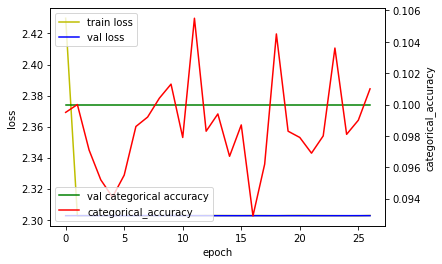

In [36]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'b', label='val loss')

acc_ax.plot(hist.history['val_categorical_accuracy'], 'g', label='val categorical accuracy')
acc_ax.plot(hist.history['categorical_accuracy'], 'r', label='categorical_accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('categorical_accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## Evaluation

In [40]:
pred_y = model.predict(test_X, batch_size= batch)

In [41]:
ppp = np.argmax(pred_y,1)

In [42]:
ttt = np.argmax(test_y,1)

In [43]:
ppp

array([115, 329,  27, ...,  50, 306, 181], dtype=int64)

In [44]:
ttt

array([115, 329, 300, ...,  50, 210, 181], dtype=int64)

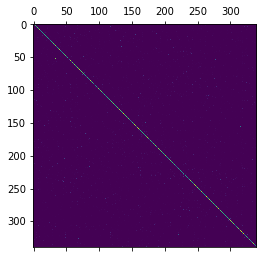

In [45]:
plt.matshow(confusion_matrix(ttt,ppp))

In [48]:
part1 = classification_report(ttt, ppp, 
                            target_names = [x for x in word_le.classes_])

* 이미지 그리기

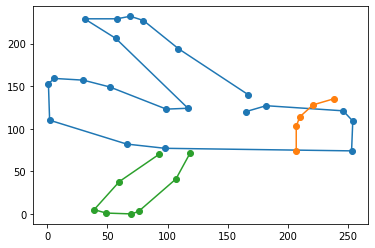

In [122]:
raw_images = list(all_data['drawing'])

k = 0
for i in range(len(raw_images[k])):
    plt.plot(raw_images[k][i][0], raw_images[k][i][1],'o-')
plt.show()

In [171]:
def get_Xy(in_df):
    X = np.stack(in_df['drawing'], 0)
    y = to_categorical(word_encoder.transform(in_df['word'].values))
    return X, y
train_X, train_y = get_Xy(train_df)
valid_X, valid_y = get_Xy(valid_df)
test_X, test_y = get_Xy(test_df)
print(train_X.shape)

NameError: name 'train_df' is not defined

In [108]:

stroke_read_model = Sequential()
stroke_read_model.add(BatchNormalization(input_shape = (None,)))
# filter count and length are taken from the script https://github.com/tensorflow/models/blob/master/tutorials/rnn/quickdraw/train_model.py
stroke_read_model.add(Conv1D(48, (5,)))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Conv1D(64, (5,)))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Conv1D(96, (3,)))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(LSTM(128, return_sequences = True))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(LSTM(128, return_sequences = False))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Dense(512))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Dense(len(word_encoder.classes_), activation = 'softmax'))
stroke_read_model.compile(optimizer = 'adam', 
                          loss = 'categorical_crossentropy', 
                          metrics = ['categorical_accuracy', top_3_accuracy])
stroke_read_model.summary()

ValueError: Axis -1 of input tensor should have a defined dimension but the layer received an input with shape (None, None).